In [18]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle 
import os
from torchvision import transforms 
from build_vocab import Vocabulary
from model import EncoderCNN, DecoderRNN
from PIL import Image
import os
from glob import glob

In [29]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab_path = "../data/vocab.pkl"
encoder_path ="../trained_models/exp_lstm_512/encoder-3-3000.ckpt"
decoder_path = "../trained_models/exp_lstm_512/decoder-3-3000.ckpt"
test_data_path = "/datasets/COCO-2015/test2015/"

In [11]:
# Load vocabulary wrapper
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

In [12]:
def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

In [13]:
# Pre-process data
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.485, 0.456, 0.406), 
                                                    (0.229, 0.224, 0.225))])

In [15]:
embed_size=256
hidden_size=512
num_layers=1

# Build models
encoder = EncoderCNN(embed_size).eval() 
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
encoder = encoder.to(device)
decoder = decoder.to(device)

# Load the trained model parameters
encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

In [59]:
def predict(image_paths):
    # Prepare an image
    for image_path in image_paths:
        image = load_image(image_path, transform)
        image_tensor = image.to(device)

        # Generate an caption from the image
        feature = encoder(image_tensor)
        sampled_ids = decoder.sample(feature)
        sampled_ids = sampled_ids[0].cpu().numpy()          
        
        # Convert word_ids to words
        sampled_caption = []
        for word_id in sampled_ids:
            word = vocab.idx2word[word_id]
            sampled_caption.append(word)
            if word == '<end>':
                break
        sentence = ' '.join(sampled_caption)

        # Print out the image and the generated caption
        image = Image.open(image_path)
        figure = plt.figure()
        plt.imshow(np.asarray(image))
        plt.title(sentence)
        plt.savefig('../bad_result_4.png')
        plt.show()


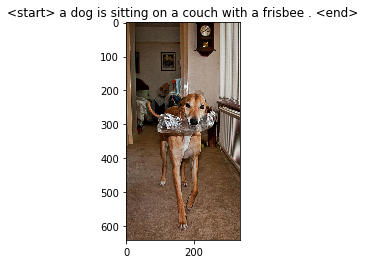

In [60]:
image_paths = glob(os.path.join(test_data_path, "*.jpg"))
predict(image_paths=image_paths[43:44])